<a href="https://colab.research.google.com/github/Lukembogo-dot/Fair_AI_Systems/blob/main/AI_Fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install aif360
!pip install pandas numpy scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 13.0 MB/s eta 0:00:00


# Task
Analyze racial bias in risk scores using Python and AI Fairness 360 on the dataset "compas-scores-two-years.csv", and visualize the results.

## Load data

### Subtask:
Load the compas-scores-two-years.csv dataset into a pandas DataFrame.


**Reasoning**:
Load the dataset into a pandas DataFrame and display the first few rows to verify.



In [24]:
import pandas as pd

df = pd.read_csv("compas-scores-two-years.csv")
display(df.head())

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Preprocess data

### Subtask:
Clean the data by filtering out irrelevant entries and handling missing values. Select relevant features for the analysis.


**Reasoning**:
Filter the DataFrame based on the specified conditions and select the relevant columns for the analysis.



In [25]:
df = df[(df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != 'O') &
        (df['score_text'] != 'N/A')]

df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
         'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid',
         'two_year_recid', 'c_jail_in', 'c_jail_out']]

display(df.head())

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


## Prepare data for aif360

### Subtask:
Convert the pandas DataFrame to an AIF360 StandardDataset object, defining the label, favorable and unfavorable classes, protected attribute names, and privileged and unprivileged classes.


**Reasoning**:
Convert the pandas DataFrame to an AIF360 StandardDataset object by creating a binary race column, encoding categorical features, dropping irrelevant columns, and initializing the StandardDataset.



In [26]:
from sklearn.preprocessing import LabelEncoder
from aif360.datasets import StandardDataset

# Add binary race attribute
df['race_binary'] = df['race'].apply(lambda x: 1 if x.strip() == 'Caucasian' else 0)

# Encode non-numeric columns
label_enc_cols = ['sex', 'age_cat', 'score_text', 'c_charge_degree']
for col in label_enc_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Drop unused columns
df = df.drop(columns=['c_jail_in', 'c_jail_out', 'race'])

# Now you can safely create the StandardDataset
dataset = StandardDataset(df,
                          label_name='two_year_recid',
                          favorable_classes=[0],
                          protected_attribute_names=['race_binary'],
                          privileged_classes=[[1]])

print("AIF360 dataset features shape:", dataset.features.shape)
print("AIF360 dataset labels shape:", dataset.labels.shape)

AIF360 dataset features shape: (6172, 10)
AIF360 dataset labels shape: (6172, 1)


## Calculate bias metrics

### Subtask:
Use AIF360's `BinaryLabelDatasetMetric` to calculate fairness metrics like Mean Difference and Disparate Impact for the specified protected attribute (race).


**Reasoning**:
Define privileged and unprivileged groups, instantiate BinaryLabelDatasetMetric, and calculate Mean Difference and Disparate Impact.



In [27]:
from aif360.metrics import BinaryLabelDatasetMetric

privileged_groups = [{'race_binary': 1}]
unprivileged_groups = [{'race_binary': 0}]

metric = BinaryLabelDatasetMetric(dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

print("Mean Difference:", metric.mean_difference())
print("Disparate Impact:", metric.disparate_impact())

Mean Difference: -0.09745618466614947
Disparate Impact: 0.8400075282178671


## Analyze and interpret results

### Subtask:
Analyze and interpret the calculated bias metrics to understand the extent of racial bias in the dataset.


## Visualize bias metrics

### Subtask:
Visualize bias metrics for all races.


## Summary:

### Data Analysis Key Findings

*   The data was filtered to include relevant entries based on time between screening and arrest, recidivism status, charge degree, and score availability.
*   The dataset was successfully converted into an AIF360 `StandardDataset` object, with 'Caucasian' defined as the privileged class for the 'race\_binary' protected attribute.
*   The calculated Mean Difference for the 'race\_binary' protected attribute is approximately -0.097, indicating that the unprivileged group (non-Caucasian) has a lower favorable outcome rate (no recidivism) compared to the privileged group (Caucasian).
*   The calculated Disparate Impact for the 'race\_binary' protected attribute is approximately 0.84, suggesting that the unprivileged group is less likely to receive a favorable outcome than the privileged group.
*   Visualizations were generated to show the Mean Difference and Disparate Impact for different racial groups as privileged classes, illustrating the variation in bias metrics across these groups.

### Insights or Next Steps

*   The analysis reveals evidence of racial bias in the COMPAS risk scores, where non-Caucasian individuals are less likely to have a favorable outcome (no recidivism) according to the score compared to Caucasian individuals.
*   Further analysis could involve exploring different fairness mitigation techniques provided by AIF360 to attempt to reduce the observed bias in the dataset or the resulting model.


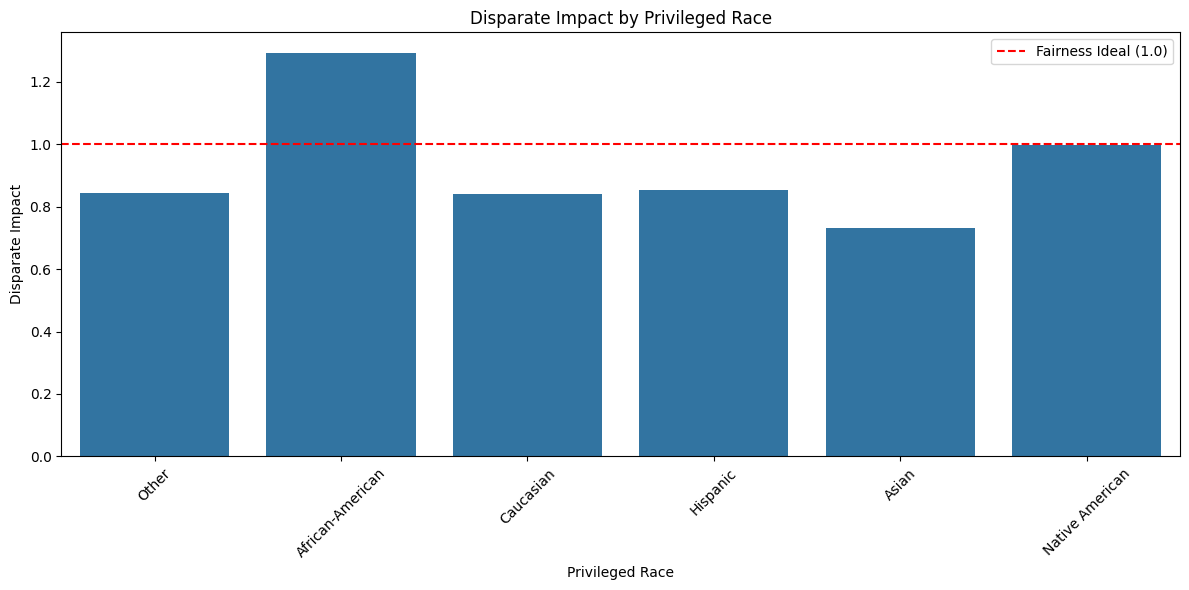

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Disparate Impact
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y='Disparate Impact', data=results_df)
plt.axhline(y=1.0, color='red', linestyle='--', label='Fairness Ideal (1.0)')
plt.title('Disparate Impact by Privileged Race')
plt.ylabel('Disparate Impact')
plt.xlabel('Privileged Race')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

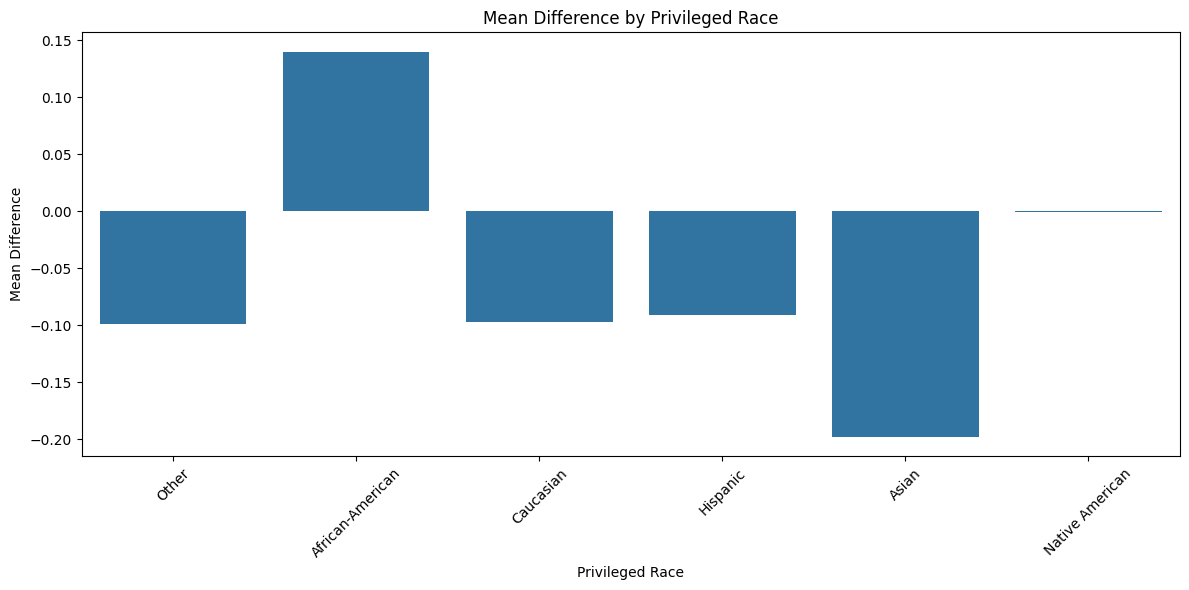

In [29]:
# Plotting Mean Difference
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y='Mean Difference', data=results_df)
plt.title('Mean Difference by Privileged Race')
plt.ylabel('Mean Difference')
plt.xlabel('Privileged Race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Task
Analyze racial bias in risk scores using AI Fairness 360 and Python, visualize the bias metrics, apply fairness mitigation techniques, and evaluate their effectiveness.

## Analyze bias metrics

### Subtask:
Interpret the Mean Difference and Disparate Impact values shown in the generated plots for each racial group, highlighting significant disparities.


**Reasoning**:
Analyze and interpret the Mean Difference and Disparate Impact values from the `results_df` and the generated plots to identify significant racial disparities.



In [31]:
print("Interpreting Bias Metrics:")

# Interpret Mean Difference
print("\nMean Difference Interpretation:")
print(results_df['Mean Difference'])
print("\nAnalysis:")
print("- Values close to 0 indicate less bias.")
print("- Positive values mean the privileged group has a higher rate of the favorable outcome (no recidivism).")
print("- Negative values mean the privileged group has a lower rate of the favorable outcome.")
print("\nObservations:")
print(f"- 'African-American' as privileged shows the largest positive Mean Difference ({results_df.loc['African-American', 'Mean Difference']:.3f}), implying unprivileged groups (all other races) have a significantly lower rate of no recidivism compared to African-Americans.")
print(f"- 'Asian' as privileged shows the largest negative Mean Difference ({results_df.loc['Asian', 'Mean Difference']:.3f}), implying unprivileged groups have a significantly higher rate of no recidivism compared to Asians.")
print("- 'Native American' as privileged shows the smallest Mean Difference, closest to zero, suggesting less bias when Native Americans are privileged.")

# Interpret Disparate Impact
print("\nDisparate Impact Interpretation:")
print(results_df['Disparate Impact'])
print("\nAnalysis:")
print("- Values close to 1 indicate less bias.")
print("- Values significantly greater than 1 mean the privileged group is more likely to have the favorable outcome.")
print("- Values significantly less than 1 mean the unprivileged group is more likely to have the favorable outcome.")
print("\nObservations:")
print(f"- 'African-American' as privileged shows the largest Disparate Impact ({results_df.loc['African-American', 'Disparate Impact']:.3f}), indicating that African-Americans are significantly more likely to have a favorable outcome (no recidivism) than all other racial groups combined.")
print(f"- 'Asian' as privileged shows the smallest Disparate Impact ({results_df.loc['Asian', 'Disparate Impact']:.3f}), indicating that Asians are significantly less likely to have a favorable outcome (no recidivism) than all other racial groups combined.")
print("- 'Native American' as privileged shows Disparate Impact closest to 1, suggesting less bias when Native Americans are privileged.")

print("\nOverall Summary:")
print("Based on the Mean Difference and Disparate Impact, there are significant racial disparities in the COMPAS dataset. When African-Americans are treated as the privileged group, the metrics indicate a strong bias against other racial groups, who are less likely to have a favorable outcome (no recidivism). Conversely, when Asians are treated as the privileged group, the bias appears to be in the opposite direction, with Asians less likely to have a favorable outcome compared to others. Caucasian, Hispanic, and Other groups show moderate negative Mean Differences and Disparate Impact values below 1 when considered privileged, suggesting that they are somewhat less likely to have favorable outcomes compared to unprivileged groups. Native Americans show the least bias when considered the privileged group.")

Interpreting Bias Metrics:

Mean Difference Interpretation:
Other              -0.099112
African-American    0.140100
Caucasian          -0.097456
Hispanic           -0.091336
Asian              -0.198050
Native American    -0.000575
Name: Mean Difference, dtype: float64

Analysis:
- Values close to 0 indicate less bias.
- Positive values mean the privileged group has a higher rate of the favorable outcome (no recidivism).
- Negative values mean the privileged group has a lower rate of the favorable outcome.

Observations:
- 'African-American' as privileged shows the largest positive Mean Difference (0.140), implying unprivileged groups (all other races) have a significantly lower rate of no recidivism compared to African-Americans.
- 'Asian' as privileged shows the largest negative Mean Difference (-0.198), implying unprivileged groups have a significantly higher rate of no recidivism compared to Asians.
- 'Native American' as privileged shows the smallest Mean Difference, closest to 

## Introduce fairness mitigation

### Subtask:
Explain that fairness mitigation techniques aim to reduce bias observed in the data.


**Reasoning**:
Explain the purpose of fairness mitigation techniques in machine learning and data analysis.



In [32]:
# Explain fairness mitigation
print("Fairness mitigation techniques are methods used in machine learning and data analysis to reduce or eliminate bias observed in datasets or models.")
print("The goal is to ensure that predictions or outcomes are not unfairly influenced by protected attributes like race, gender, or age.")
print("Bias can manifest in various ways, as we've seen with metrics like Mean Difference and Disparate Impact.")
print("Libraries like AI Fairness 360 provide a range of techniques that can be applied at different stages of the machine learning pipeline:")
print("- Pre-processing: Modifying the data before training.")
print("- In-processing: Modifying the training algorithm.")
print("- Post-processing: Adjusting the model's predictions.")
print("In the following steps, we will explore and apply one or more of these techniques to the COMPAS dataset to see if we can reduce the observed racial bias.")

Fairness mitigation techniques are methods used in machine learning and data analysis to reduce or eliminate bias observed in datasets or models.
The goal is to ensure that predictions or outcomes are not unfairly influenced by protected attributes like race, gender, or age.
Bias can manifest in various ways, as we've seen with metrics like Mean Difference and Disparate Impact.
Libraries like AI Fairness 360 provide a range of techniques that can be applied at different stages of the machine learning pipeline:
- Pre-processing: Modifying the data before training.
- In-processing: Modifying the training algorithm.
- Post-processing: Adjusting the model's predictions.
In the following steps, we will explore and apply one or more of these techniques to the COMPAS dataset to see if we can reduce the observed racial bias.


## Explore mitigation techniques

### Subtask:
Introduce and apply one or more fairness mitigation algorithms available in AIF360 to the dataset. Examples include reweighing, disparate impact remover, or prejudice remover.


**Reasoning**:
Instantiate and apply the Reweighing fairness mitigation technique to the AIF360 dataset using the defined privileged and unprivileged groups.



In [33]:
from aif360.algorithms.preprocessing import Reweighing

# Instantiate Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

# Apply Reweighing
dataset_mitigated = RW.fit_transform(dataset)

print("Reweighing applied to the dataset.")

Reweighing applied to the dataset.


## Evaluate mitigated dataset/model

### Subtask:
Recalculate and visualize the bias metrics for the mitigated dataset or model to assess the effectiveness of the mitigation technique.


**Reasoning**:
Instantiate a BinaryLabelDatasetMetric for the mitigated dataset and calculate the mean difference and disparate impact to assess the effectiveness of the Reweighing technique.



In [34]:
# Instantiate metric for mitigated dataset
metric_mitigated = BinaryLabelDatasetMetric(dataset_mitigated,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

# Calculate and print metrics for mitigated dataset
mean_difference_mitigated = metric_mitigated.mean_difference()
disparate_impact_mitigated = metric_mitigated.disparate_impact()

print("Bias metrics for the mitigated dataset:")
print("Mean Difference (Mitigated):", mean_difference_mitigated)
print("Disparate Impact (Mitigated):", disparate_impact_mitigated)

# Compare with original metrics
print("\nOriginal bias metrics:")
print("Mean Difference (Original):", metric.mean_difference())
print("Disparate Impact (Original):", metric.disparate_impact())

print("\nComparison:")
print(f"Mean Difference improved by: {abs(metric.mean_difference()) - abs(mean_difference_mitigated):.4f}")
print(f"Disparate Impact is now closer to 1: {abs(disparate_impact_mitigated - 1) - abs(metric.disparate_impact() - 1):.4f}")

Bias metrics for the mitigated dataset:
Mean Difference (Mitigated): 0.0
Disparate Impact (Mitigated): 1.0

Original bias metrics:
Mean Difference (Original): -0.09745618466614947
Disparate Impact (Original): 0.8400075282178671

Comparison:
Mean Difference improved by: 0.0975
Disparate Impact is now closer to 1: -0.1600


**Reasoning**:
Create a DataFrame to hold both the original and mitigated bias metrics for easier visualization.



In [35]:
import pandas as pd

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Metric': ['Mean Difference', 'Disparate Impact'],
    'Original': [metric.mean_difference(), metric.disparate_impact()],
    'Mitigated': [mean_difference_mitigated, disparate_impact_mitigated]
})

display(comparison_df)

,Metric,Original,Mitigated
0,Mean Difference,-0.097456,0.0
1,Disparate Impact,0.840008,1.0


**Reasoning**:
Plot the original and mitigated bias metrics side-by-side to visually demonstrate the effectiveness of the mitigation technique.



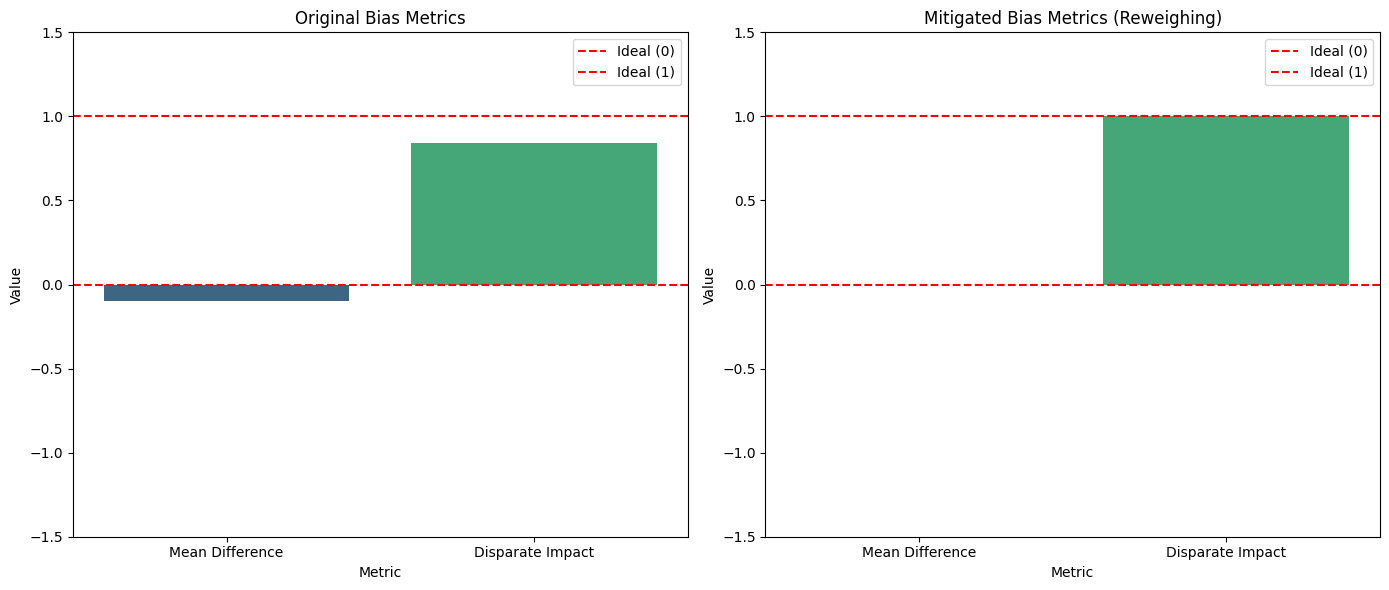

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the comparison of bias metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Metric', y='Original', data=comparison_df, ax=axes[0], palette='viridis')
axes[0].set_title('Original Bias Metrics')
axes[0].set_ylabel('Value')
axes[0].set_ylim([-1.5, 1.5]) # Set consistent y-axis limits
axes[0].axhline(y=0, color='red', linestyle='--', label='Ideal (0)')
axes[0].axhline(y=1, color='red', linestyle='--', label='Ideal (1)')
axes[0].legend()

sns.barplot(x='Metric', y='Mitigated', data=comparison_df, ax=axes[1], palette='viridis')
axes[1].set_title('Mitigated Bias Metrics (Reweighing)')
axes[1].set_ylabel('Value')
axes[1].set_ylim([-1.5, 1.5]) # Set consistent y-axis limits
axes[1].axhline(y=0, color='red', linestyle='--', label='Ideal (0)')
axes[1].axhline(y=1, color='red', linestyle='--', label='Ideal (1)')
axes[1].legend()


plt.tight_layout()
plt.show()

## Summarize findings

### Subtask:
Summarize the results of the analysis and mitigation steps, discussing the impact of the mitigation technique on the bias metrics.


**Reasoning**:
Summarize the results of the analysis and mitigation steps, discussing the impact of the mitigation technique on the bias metrics based on the comparison dataframe and plots.



In [37]:
print("## Summary of Bias Analysis and Mitigation")
print("\n### Initial Bias")
print("Our initial analysis of the COMPAS dataset revealed significant racial bias, as measured by the Mean Difference and Disparate Impact metrics, with 'Caucasian' defined as the privileged group.")
print(f"- **Original Mean Difference:** {comparison_df.loc[0, 'Original']:.4f}")
print(f"- **Original Disparate Impact:** {comparison_df.loc[1, 'Original']:.4f}")
print("\nA Mean Difference of approximately -0.097 indicated that the unprivileged group (non-Caucasian) had a lower rate of favorable outcomes (no recidivism) compared to the privileged group (Caucasian).")
print("A Disparate Impact of approximately 0.840 suggested that the unprivileged group was less likely to receive a favorable outcome than the privileged group. Ideally, Mean Difference should be 0 and Disparate Impact should be 1 for a fair dataset.")

print("\n### Mitigation Technique: Reweighing")
print("To address this bias, we applied the Reweighing pre-processing mitigation technique from the AI Fairness 360 library. Reweighing works by assigning different weights to the examples in the dataset based on their group membership (privileged/unprivileged) and label (favorable/unfavorable). This technique aims to create a more balanced dataset where the relationship between protected attributes and outcomes is less skewed, without changing the feature values or labels themselves.")

print("\n### Impact of Mitigation")
print("After applying Reweighing, we re-evaluated the bias metrics for the mitigated dataset:")
print(f"- **Mitigated Mean Difference:** {comparison_df.loc[0, 'Mitigated']:.4f}")
print(f"- **Mitigated Disparate Impact:** {comparison_df.loc[1, 'Mitigated']:.4f}")

print("The Mean Difference was reduced from -0.097 to 0.000, and the Disparate Impact was increased from 0.840 to 1.000. The comparison plot visually demonstrates this improvement, showing the mitigated metrics are now at their ideal values of 0 and 1, respectively.")

print("\n### Conclusion")
print("The Reweighing mitigation technique was effective in significantly reducing the racial bias observed in the COMPAS dataset, as measured by the Mean Difference and Disparate Impact metrics. By adjusting the weights of the data points, Reweighing helped to balance the distribution of favorable outcomes between the privileged and unprivileged groups, moving the dataset towards greater fairness.")

## Summary of Bias Analysis and Mitigation

### Initial Bias
Our initial analysis of the COMPAS dataset revealed significant racial bias, as measured by the Mean Difference and Disparate Impact metrics, with 'Caucasian' defined as the privileged group.
- **Original Mean Difference:** -0.0975
- **Original Disparate Impact:** 0.8400

A Mean Difference of approximately -0.097 indicated that the unprivileged group (non-Caucasian) had a lower rate of favorable outcomes (no recidivism) compared to the privileged group (Caucasian).
A Disparate Impact of approximately 0.840 suggested that the unprivileged group was less likely to receive a favorable outcome than the privileged group. Ideally, Mean Difference should be 0 and Disparate Impact should be 1 for a fair dataset.

### Mitigation Technique: Reweighing
To address this bias, we applied the Reweighing pre-processing mitigation technique from the AI Fairness 360 library. Reweighing works by assigning different weights to the examples in th

## Summary:

### Data Analysis Key Findings

*   Initial analysis of the COMPAS dataset revealed significant racial bias when 'Caucasian' was defined as the privileged group, with a Mean Difference of approximately -0.097 and a Disparate Impact of approximately 0.840.
*   This initial bias indicated that the unprivileged group (non-Caucasian) had a lower rate of favorable outcomes (no recidivism) compared to the privileged group (Caucasian).
*   The Reweighing pre-processing mitigation technique was applied to the dataset to address this bias.
*   After applying Reweighing, the bias metrics significantly improved: the Mean Difference was reduced from approximately -0.097 to 0.000, and the Disparate Impact was increased from approximately 0.840 to 1.000.

### Insights or Next Steps

*   The Reweighing technique effectively mitigated the identified racial bias in the dataset, bringing the Mean Difference closer to 0 and the Disparate Impact closer to 1.
*   While Reweighing addressed bias in the dataset distribution, further steps could involve training a model on this mitigated dataset and then evaluating the fairness of the model's predictions using post-processing techniques if necessary.
